In [4]:
%pylab inline
import theano as theano
import theano.tensor as T
import operator
import os, csv

Populating the interactive namespace from numpy and matplotlib


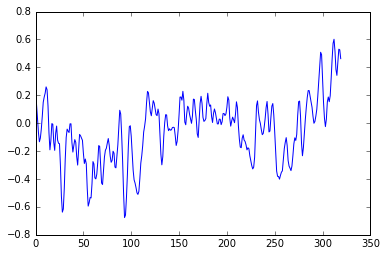

In [5]:
data_to_charge = 0 # 0 is for the music samples, 1 is for TIMIT
if data_to_charge not in (0, 1):
    raise ValueError("data_to_charge must be 0 (music) or 1 (speech)")
elif data_to_charge == 0:
    data_folder = "../sample/"
else:
    data_folder = "../timit"

files_names = (os.listdir(data_folder))
folder_size = len(files_names)
sample_lenght = 0

cr = csv.reader(open(data_folder + files_names[0], "r"))
for row in cr:
    sample_lenght += 1

data = np.zeros((folder_size, sample_lenght, 2))
    
for file_number, file in enumerate(files_names):
    cr = csv.reader(open(data_folder + file, "r"))
    for row_number, row in enumerate(cr):
        data[file_number][row_number] = [float(row[0]), float(row[1])]
        
plot(data[4][:,0])

In [17]:
class RNNTheano:
    
    def __init__(self, word_dim=1, hidden_dim=9, bptt_truncate=4):
        # Assign instance variables
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Randomly initialize the network parameters
        V = np.random.normal(0,0.1, (word_dim, hidden_dim))
        W = np.random.normal(0,0.1, (hidden_dim, hidden_dim))
        #b1 = np.random.normal(0,0.1, (hidden_dim))
        # Theano: Created shared variables
        self.V = theano.shared(name='V', value=V.astype(theano.config.floatX))
        self.W = theano.shared(name='W', value=W.astype(theano.config.floatX))      
        #self.b1 = theano.shared(name='b1', value=b1.astype(theano.config.floatX))      
        # We store the Theano graph here
        self.theano = {}
        self.__theano_build__()
    
    def __theano_build__(self):
        V, W= self.V, self.W
        #b1 = self.b1
        x = T.vector('x')
        def forward_prop_step(x_t, s_t_prev, V, W):
            s_t = T.tanh(W.dot(s_t_prev))
            o_t = V.dot(s_t)
            print(o_t)
            return [o_t[0], s_t]
        [o,s], updates = theano.scan(
            forward_prop_step,
            sequences=x,
            outputs_info=[None, dict(initial=T.ones(self.hidden_dim)*x[0])],
            non_sequences=[V, W],
            truncate_gradient=self.bptt_truncate,
            strict=True)
        
        prediction = o
        o_error = T.mean((x - o) ** 2)
        
        # Gradients
        dV = T.grad(o_error, V)
        dW = T.grad(o_error, W)
        #db1 = T.grad(o_error, b1)

        
        # Assign functions
        self.forward_propagation = theano.function([x], o)
        self.predict = theano.function([x], prediction)
        self.ce_error = theano.function([x], o_error)
        self.bptt = theano.function([x], [dV, dW])
        
        # SGD
        learning_rate = T.scalar('learning_rate')
        self.sgd_step = theano.function([x,learning_rate], 
                      updates=[(self.V, self.V - learning_rate * dV),
                              (self.W, self.W - learning_rate * dW)])
    
    def calculate_loss(self, x):
        return self.ce_error(x)

In [23]:
def train_with_sgd(model, x, learning_rate=0.005, nepoch=100, momentum=0.95):
    # We keep track of the losses so we can plot them later
    losses = []
    for epoch in range(nepoch):
        loss = model.calculate_loss(x)
        losses.append(loss)
        # One SGD step
        model.sgd_step(x, learning_rate)
    return losses


In [19]:
model = RNNTheano()

dot.0


/usr/local/lib/python3.4/dist-packages/theano/scan_module/scan.py:1017: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)


In [24]:
X_train = data[4][:,0]
X_train = np.ones(320)
losses = train_with_sgd(model, X_train, nepoch=2000)

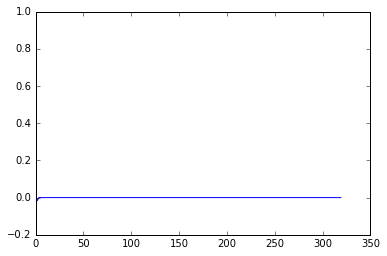

In [25]:
o = model.predict(X_train)
plot(o)
plot(X_train)

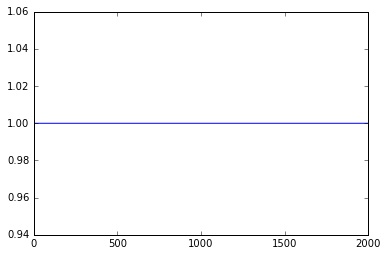

In [26]:
plot(losses)

In [18]:
model.b1[:]

Subtensor{::}.0